# Bayesian logistic regression:

In [1]:
import jax.numpy as jnp
from jaxtyping import Array, Float
from dataclasses import dataclass

import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import distrax as dx

from coinem.model import AbstractModel

## Model

We employ standard Bayesian logistic regression with Gaussian priors. That is, we assume that the datapoints’ labels are conditionally independent given the features $f$ and regression weights $x \in \mathbb{R}^{Dy:=9}$, each label with Bernoulli law and mean $s(f^T x)$, where $s(z) := e^z/(1 + e^z)$ denotes the standard logistic function; and we assign the prior $\mathcal{N}(x; \theta I_{D_y}, 5I_{D_y})$ to the weights $x$, where $\theta$ denotes the (scalar) parameter to be estimated. The model’s density is given by:

$$ p_\theta(x, y) = \mathcal{N}(x; \theta I_{D_y}, 5I_{D_y}) \prod_{f, l} s(f^{T} x)^{l} \left[ 1 - s(f^{T} x) \right]^{1-l}$$

### Model in code:
To create our model we just inherit from the provided `AbstractModel`.

In [2]:
@dataclass
class LogisticRegression(AbstractModel):
    """Base class for p(θ, x).
    
    """
    f: Float[Array, "Ny 9"] # Features
    y: Float[Array, "Ny 1"] # Labels
    
    def log_prob(self, latent: Float[Array, "D 1"], theta: Float[Array, "Q"]) -> Float[Array, ""]:
        """Compute gradient of the objective function at x.

        Args:
            latent (Float[Array, "D"]): Input weights of shape (D,).
            theta (Float[Array, "Q"]): Parameters of shape (Q,).

        Returns:
            Float[Array, ""]: log-probability of the data.
        """

        # Compute linear predictor.
        z = jnp.matmul(self.f, latent)

        # Compute log-probability.
        return jnp.sum(self.y.squeeze() * z - jnp.log(1.0 + jnp.exp(z))) - jnp.sum((latent-theta)**2)/5

### Dataset:

We use the Wisconsin Breast Cancer dataset Y (Wolberg and Mangasarian, 1990), created by Dr. William H. Wolberg at the University of Wisconsin Hospitals, and freely available at
https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(original).
It contains 683 datapoints5 each with nine features f ∈ R9 extracted from a digitized image of a fine needle aspirate of a breast mass and an accompanying label l indicating whether the mass is benign (l = 0) or malign (l = 1). We normalize the features so that each has mean zero and unit standard deviation across the dataset. We split the dataset into 80/20 training and testing sets, Ytrain and Ytest.

In [3]:
# OS and wget to load dataset.
import os
import wget
import numpy as np

# Fetch dataset from repository:
wget.download('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data')

# Load dataset:
dataset = np.loadtxt('breast-cancer-wisconsin.data', dtype=str, delimiter=',')

# Delete local copy of dataset to avoid duplicates with multiple notebook runs:
os.remove('breast-cancer-wisconsin.data')

# Remove datapoints with missing attributes and change dtype to float:
dataset = dataset[~(dataset == '?').any(axis=1), :].astype(float)

# Extract features and labels, and normalize features:
features = np.array(dataset[:, 1:10] - dataset[:, 1:10].mean(0))
features = features/features.std(0)
labels = np.array([(dataset[:, 10]-2)/2]).transpose()

# Split data into 80/20 training and testing sets:
from sklearn.model_selection import train_test_split
ftrain, ftest, ltrain, ltest = train_test_split(features, labels, test_size=0.2, 
                                                random_state=0)

### Unit tests:
We test the score of the latent function and average log-probability of the model.

In [4]:
# Define the model:
model = LogisticRegression(f=ftrain, y=ltrain)

# Unit tests:
N = 10  # Number of particles.
D = 9  # Dimension of latent space.

theta = jnp.array([0.0]) # Parameters of the model.
latent_particles = jnp.zeros((N, D)) # Latent particles.

f = ftrain # Features
y = ltrain # Labels

s = 1.0/(1.0+jnp.exp(-jnp.matmul(f, latent_particles.T)))
score_latent_particles = (jnp.matmul((y-s).T, f).T - (latent_particles.T)/5).T
average_score_theta = jnp.array([[2 * (latent_particles.T).sum(0).mean()/5]])

assert jnp.allclose(model.score_latent_particles(latent_particles, theta), score_latent_particles) # Gradient of log p(y|x) wrt latent particles
assert jnp.allclose(model.average_score_theta(latent_particles, theta), average_score_theta) # Average gradient of log p(y|x) wrt theta

# Experiments

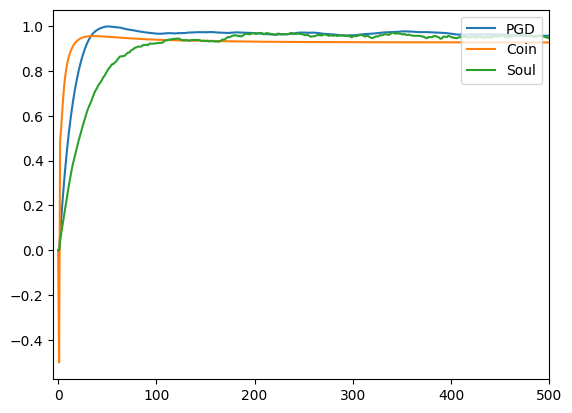

In [12]:
from coinem.zoo import coin_svgd, pgd, soul

import jax.random as jr
key = jr.PRNGKey(123)

h = 1e-2 # Step-size. 
K = 500  # Number of steps.
N = 100  # Number of particles.

th0 = jnp.array([[0.0]])  # Parameter estimate.
X0 = jr.normal(key, (N, D))  # Particle cloud.

X_coin, th_coin = coin_svgd(model, X0, th0, K)
X_pgd, th_pgd = pgd(model, X0, th0, K, step_size=h)
X_soul, th_soul = soul(model, X0, th0, K, step_size=h)


plt.plot(th_pgd.squeeze(), label='PGD')
plt.xlim([-K/100, K])
plt.plot(th_coin.squeeze(), label='Coin')
plt.plot(th_soul.squeeze(), label='Soul')
plt.legend(loc='upper right')


(-5.0, 500.0)

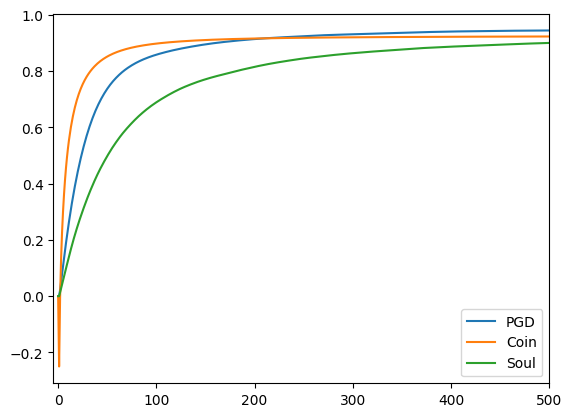

In [13]:
from coinem.utils import cum_mean as cmean

plt.plot(cmean(th_pgd).squeeze(), label='PGD')
#plt.plot(cmean(th_pqn), label='PQN')
#plt.plot(cmean(th_pmgd), label='PMGD')
plt.plot(cmean(th_coin).squeeze(), label='Coin')
plt.plot(cmean(th_soul).squeeze(), label='Soul')

#plt.plot(cmean(th_coinS), label='Coin Sampling')
#plt.plot(th_em, label='EM')
plt.legend(loc='lower right')
plt.xlim([-K/100, K])

## Latent posterior analysis:

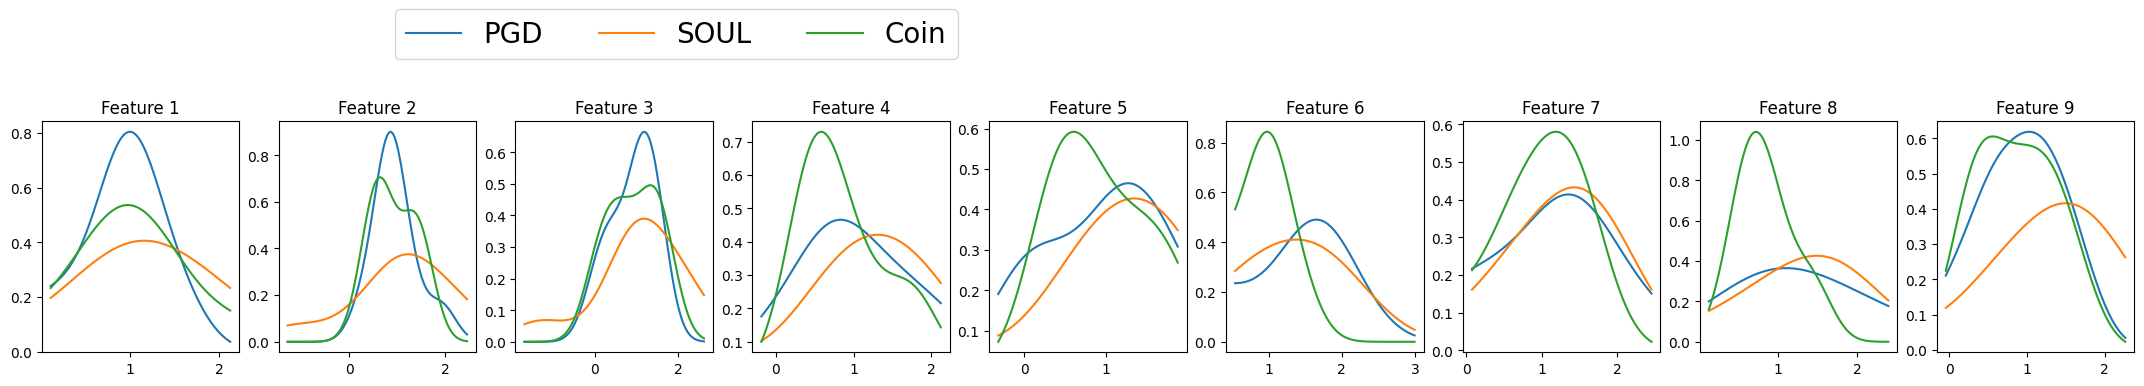

In [14]:
# Extract final particle clouds X^{1:N}_K:
q_pgd = X_pgd[-1]
#q_pqn = X_pqn[:, -N:]
#q_vi = X_vi[:, -N:]
#q_pmgd = X_pmgd[:, -N:]
q_soul = X_soul[-1]
q_coin = X_coin[-1]

# Generate and plot KDEs:
from scipy import stats  # stats to generate KDEs.
fig = plt.figure(figsize=(27,3), dpi= 100)
for i in range(D):
    # Generate KDEs for ith entry of the final particle cloud X^{1:N}_K:
    kde_min = np.min([q_pgd[:, i], q_coin[:, i]])
    kde_max = np.max([q_pgd[:, i], q_coin[:, i]])
    xaxis = np.linspace(kde_min, kde_max, num=100)

    kde_pgd = stats.gaussian_kde(q_pgd[i, :])(xaxis)
    #kde_pqn = stats.gaussian_kde(q_pqn[i, :])(xaxis)
    #kde_vi = stats.norm.pdf(xaxis, loc=m_vi[i], scale=s_vi[i] ** 0.5)
    #kde_pmgd = stats.gaussian_kde(q_pmgd[i, :])(xaxis)
    kde_soul = stats.gaussian_kde(q_soul[i, :])(xaxis)
    kde_coin = stats.gaussian_kde(q_coin[i, :])(xaxis)


    # Plot KDEs:
    plt.subplot(1, D, i+1)
    #plt.plot(xaxis, kde_vi, label='VI')
    plt.plot(xaxis, kde_pgd, label='PGD')
    #plt.plot(xaxis, kde_pgd, label='PGD')
    #plt.plot(xaxis, kde_pqn, label='PQN')
    #plt.plot(xaxis, kde_pmgd, label='PMGD')
    plt.plot(xaxis, kde_soul, label='SOUL')
    plt.plot(xaxis, kde_coin, label='Coin')
    plt.title('Feature ' + str(i+1))
    #plt.ylim([0, 1.02*np.max([kde_pgd, kde_pqn, kde_pmgd, kde_soul, kde_vi, kde_coin])])
    #plt.xlim([kde_min, kde_max])
    
    
handles, figlabels = plt.gca().get_legend_handles_labels()
fig.legend(handles, figlabels, ncol=4, bbox_to_anchor=(0.36,1.3), 
           loc="upper center",fontsize=20)
plt.subplots_adjust(hspace=0.6)

## Figure 3c

To spot clear differences between behaviour of the SOUL and VI parameter estimates and those of PGD, PQN, and PMGD, we initialize the estimates far from the optimal parameter and the particle cloud far from the corresponding posterior mode:

In [ ]:
th0 = np.array([[10]])
X0 = 10*np.random.randn(D, N) #NOTE that I've changed this from np.zeros for everyone

With this initialization, the PGD, PQN, and PMGD estimates exhibit slower transients than the SOUL and VI estimates:

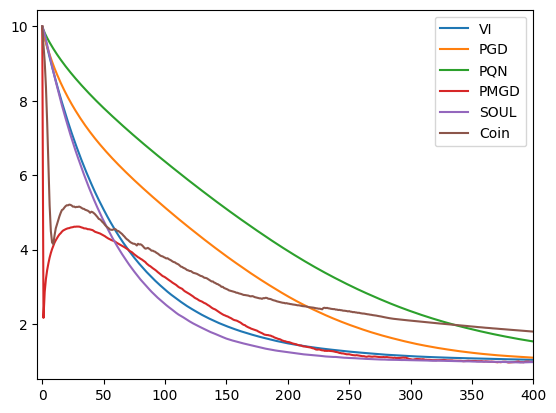

In [ ]:
# Re-run algorithms:
th_vi, X_vi, _, _ = vi(ltrain, ftrain, h, K, N, th0, X0)
th_pgd, X_pgd = pgd(ltrain, ftrain, h, K, N, th0, X0)
th_pqn, X_pqn = pqn(ltrain, ftrain, h, K, N, th0, X0)
th_pmgd, X_pmgd = pmgd(ltrain, ftrain, h, K, N, th0, X0)
th_soul, X_soul = soul(ltrain, ftrain, h, K, N, th0, X0)
th_coin, X_coin = coin(ltrain, ftrain, K, N, th0, X0)


# Plot parameter estimates:
plt.plot(th_vi, label='VI') 
plt.plot(th_pgd, label='PGD') 
plt.plot(th_pqn, label='PQN')
plt.plot(th_pmgd, label='PMGD')
plt.plot(th_soul, label='SOUL')
plt.plot(th_coin, label='Coin')
plt.xlim([-K/100, K])
plt.legend(loc='upper right')

However, we can cheaply burn off these long transients using a single-particle run. 

In [ ]:
# Warm-start using a single-particle run:
th_burn, X_burn = pmgd(ltrain, ftrain, h, K, 1, th0, X0)
th0 = th_burn[-1].reshape((1, 1))
X0 = X_burn[:, -1].reshape((D, 1))*np.ones((1, N))  

# Run the warm-started algorithms:
th_vi, X_vi, _, _ = vi(ltrain, ftrain, h, K, N, th0, X0, mu=np.mean(X0, 1))
th_pgd, X_pgd = pgd(ltrain, ftrain, h, K, N, th0, X0)
th_pqn, X_pqn = pqn(ltrain, ftrain, h, K, N, th0, X0)
th_pmgd, X_pmgd = pmgd(ltrain, ftrain, h, K, N, th0, X0)
th_soul, X_soul = soul(ltrain, ftrain, h, K, N, th0, X0)

The estimates produced by all five warm-started algorithms are similar:

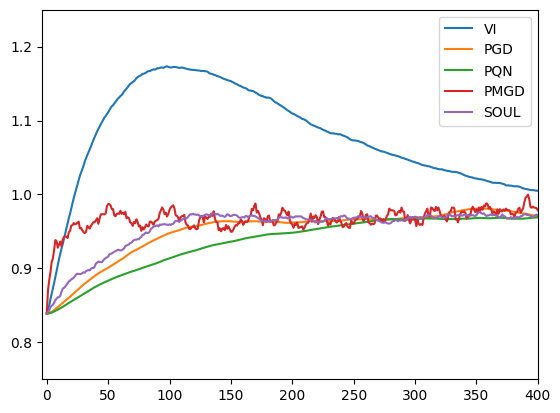

In [ ]:
plt.plot(th_vi, label='VI') 
plt.plot(th_pgd, label='PGD')
plt.plot(th_pqn, label='PQN')
plt.plot(th_pmgd, label='PMGD')
plt.plot(th_soul, label='SOUL')
plt.xlim([-K/100, K])
plt.ylim([0.75, 1.25])
plt.legend(loc='upper right')

# Table 1

We benchmark performance of the algorithms by running them several times. First, we examine their predictive performance, which we evaluate using two metrics: the test error and log pointwise predictive density (see Appendix E.2 for definitions). 

In [ ]:
#@title Performance metrics.

def predict(f, X):
    """Returns label maximizing the approximate posterior predictive 
    distribution defined by the cloud X, vectorized over feature vectors f.
    """
    s = 1/(1+np.exp(- np.matmul(f, X))).mean(1)
    out = np.zeros((f[:, 0].size, 1))
    out[s >= 1/2] = 1
    return out


def test_error(f, l, X):
    """Returns fraction of misclassified test points."""
    return (np.abs(l - predict(f, X))).mean()


def lppd(f, l, X):
    """Returns log pointwise predictive density."""
    s = 1/(1+np.exp(- np.matmul(f, X)))
    return np.log((((s ** l) * ((1-s) ** (1-l))).mean(1))).mean()

## Predictive performance

We compute the metrics for M=100 runs.

In [ ]:
M = 100  # Number of runs.
N = 100 # Number of particles.
kb = int(K/2)  # Number of burn-in steps.

# Set initial conditions to zero:
th0 = np.array([[0]])  # Parameter estimates.
X0 = np.random.randn(D, N)  # Particle cloud.

# Initialize arrays storing the LPPDs and test errors:
lppd_vi = np.zeros((M))
lppd_pgd = np.zeros((M))
lppd_pqn = np.zeros((M))
lppd_pmgd = np.zeros((M))
lppd_soul = np.zeros((M))
lppd_coin = np.zeros((M))

error_vi = np.zeros((M))
error_pgd = np.zeros((M))
error_pqn = np.zeros((M))
error_pmgd = np.zeros((M))
error_soul = np.zeros((M))
error_coin = np.zeros((M))

for m in range(M):
    # Randomize the 80/20 testing/training split of the data:
    ftrain, ftest, ltrain, ltest = train_test_split(features, labels, 
                                                    test_size=0.2, 
                                                    random_state=0)

    # Run the algorithms:
    _, X_vi, _, _ = vi(ltrain, ftrain, h, K, N, th0, X0)
    _, X_pgd = pgd(ltrain, ftrain, h, K, N, th0, X0)
    _, X_pqn = pqn(ltrain, ftrain, h, K, N, th0, X0)
    _, X_pmgd = pmgd(ltrain, ftrain, h, K, N, th0, X0)
    _, X_soul = soul(ltrain, ftrain, h, K, N, th0, X0)
    coinX0 = np.random.randn(D, N)  # Particle cloud.
    _, X_coin = coin(ltrain, ftrain, K, N, th0, coinX0)

    #Compute LPPDs:
    lppd_vi[m] = lppd(ftest, ltest, X_vi[:, N*kb:])
    lppd_pgd[m] = lppd(ftest, ltest, X_pgd[:, N*kb:])
    lppd_pqn[m] = lppd(ftest, ltest, X_pqn[:, N*kb:])
    lppd_pmgd[m] = lppd(ftest, ltest, X_pmgd[:, N*kb:])
    lppd_soul[m] = lppd(ftest, ltest, X_soul[:, N*kb:])
    lppd_coin[m] = lppd(ftest, ltest, X_coin[:, N*kb:])

    # Compute test errors:
    error_vi[m] = test_error(ftest, ltest, X_vi[:, N*kb:])
    error_pgd[m] = test_error(ftest, ltest, X_pgd[:, N*kb:])
    error_pqn[m] = test_error(ftest, ltest, X_pqn[:, N*kb:])
    error_pmgd[m] = test_error(ftest, ltest, X_pmgd[:, N*kb:])
    error_soul[m] = test_error(ftest, ltest, X_soul[:, N*kb:])
    error_coin[m] = test_error(ftest, ltest, X_coin[:, N*kb:])

#Print statistics (mean +- standard deviation):
print('LPPDs:')
print('VI: '+str(lppd_vi.mean())+' \u00B1 '+str(lppd_vi.std())+'.')
print('PGD: '+str(lppd_pgd.mean())+' \u00B1 '+str(lppd_pgd.std())+'.')
print('PQN: '+str(lppd_pqn.mean())+' \u00B1 '+str(lppd_pqn.std())+'.')
print('PMGD: '+str(lppd_pmgd.mean())+' \u00B1 '+str(lppd_pmgd.std())+'.')
print('SOUL: '+str(lppd_soul.mean())+' \u00B1 '+str(lppd_soul.std())+'.')
print('Coin: '+str(lppd_coin.mean())+' \u00B1 '+str(lppd_coin.std())+'.')

print('Test errors:')
print('VI: '+str(error_vi.mean())+' \u00B1 '+str(error_vi.std())+'.')
print('PGD: '+str(error_pgd.mean())+' \u00B1 '+str(error_pgd.std())+'.')
print('PQN: '+str(error_pqn.mean())+' \u00B1 '+str(error_pqn.std())+'.')
print('PMGD: '+str(error_pmgd.mean())+' \u00B1 '+str(error_pmgd.std())+'.')
print('SOUL: '+str(error_soul.mean())+' \u00B1 '+str(error_soul.std())+'.')
print('Coin: '+str(error_coin.mean())+' \u00B1 '+str(error_coin.std())+'.')

KeyboardInterrupt: 

## Stationary variance

Next, we compute the stationary variances of the parameter estimates. To ensure that all algorithms reach stationarity, we warm-start them using a single particle run:

In [ ]:
# Warm-start using a single-particle run:
th_burn, X_burn = pmgd(ltrain, ftrain, h, K, 1, th0, X0)
th0 = th_burn[-1].reshape((1, 1))
X0 = X_burn[:, -1].reshape((D, 1))*np.ones((1, N))  

# Initialize arrays storing the stationary variances:
var_vi = np.zeros((M))
var_pgd = np.zeros((M))
var_pqn = np.zeros((M))
var_pmgd = np.zeros((M))
var_soul = np.zeros((M))

for m in range(M):
    # Randomize the 80/20 testing/training split of the data:
    ftrain, ftest, ltrain, ltest = train_test_split(features, labels, 
                                                    test_size=0.2, 
                                                    random_state=0)

    # Run the algorithms:
    th_vi, _, _, _ = vi(ltrain, ftrain, h, K, N, th0, X0, mu=np.mean(X0, 1))
    th_pgd, _ = pgd(ltrain, ftrain, h, K, N, th0, X0)
    th_pqn, _ = pqn(ltrain, ftrain, h, K, N, th0, X0)
    th_pmgd, _ = pmgd(ltrain, ftrain, h, K, N, th0, X0)
    th_soul, _ = soul(ltrain, ftrain, h, K, N, th0, X0)

    # Compute variances:
    var_vi[m] = th_vi[kb:].var()
    var_pgd[m] = th_pgd[kb:].var()
    var_pqn[m] = th_pqn[kb:].var()
    var_pmgd[m] = th_pmgd[kb:].var()
    var_soul[m] = th_soul[kb:].var()


# Print statistics (mean +- standard deviation):
print('Stationary variances:')
print('VI: '+str(var_vi.mean())+' \u00B1 '+str(var_vi.std())+'.')
print('PGD: '+str(var_pgd.mean())+' \u00B1 '+str(var_pgd.std())+'.')
print('PQN: '+str(var_pqn.mean())+' \u00B1 '+str(var_pqn.std())+'.')
print('PMGD: '+str(var_pmgd.mean())+' \u00B1 '+str(var_pmgd.std())+'.')
print('SOUL: '+str(var_soul.mean())+' \u00B1 '+str(var_soul.std())+'.')

KeyboardInterrupt: 

## Runtime

Lastly, we obtain runtime statistics using Python's timeit module (note that Colab can be set to run on a CPU, GPU, or TPU by selecting Runtime --> Change runtime type --> Hardware accelerator):

In [ ]:
from timeit import repeat

# Time the algorithms:
t_vi = np.array(repeat(stmt='vi(ltrain, ftrain, h, K, N, th0, X0)',
                        number=1, repeat=M, globals=globals()))
t_pgd = np.array(repeat(stmt='pgd(ltrain, ftrain, h, K, N, th0, X0)',
                        number=1, repeat=M, globals=globals()))
t_pqn = np.array(repeat(stmt='pqn(ltrain, ftrain, h, K, N, th0, X0)',
                        number=1, repeat=M, globals=globals()))
t_pmgd = np.array(repeat(stmt='pmgd(ltrain, ftrain, h, K, N, th0, X0)',
                         number=1, repeat=M, globals=globals()))
t_soul = np.array(repeat(stmt='soul(ltrain, ftrain, h, K, N, th0, X0)',
                         number=1, repeat=M, globals=globals()))

# Print statistics (mean +- standard deviation):
print('Runtimes:')
print('VI: '+str(t_vi.mean())+' \u00B1 '+str(t_vi.std())+'.')
print('PGD: '+str(t_pgd.mean())+' \u00B1 '+str(t_pgd.std())+'.')
print('PQN: '+str(t_pqn.mean())+' \u00B1 '+str(t_pqn.std())+'.')
print('PMGD: '+str(t_pmgd.mean())+' \u00B1 '+str(t_pmgd.std())+'.')
print('SOUL: '+str(t_soul.mean())+' \u00B1 '+str(t_soul.std())+'.')